In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from cnnlstmnetwork import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CNNLSTMDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

In [4]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [5]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 101/101 [00:20<00:00,  5.04it/s, batch_loss=0.499, running_loss=54.3]


Train Loss: 54.2910 | Valid Loss: inf ===========> 16.8975 | Test Loss: 19.7825 | Saving model...


Epoch [2/200]: 100%|██████████| 101/101 [00:20<00:00,  4.99it/s, batch_loss=4.28, running_loss=56]


Train Loss: 56.0027 | Valid Loss: 17.7635


Epoch [3/200]: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s, batch_loss=0.36, running_loss=53.2]


Train Loss: 53.2310 | Valid Loss: 16.9602


Epoch [4/200]: 100%|██████████| 101/101 [00:20<00:00,  4.97it/s, batch_loss=0.301, running_loss=53.1]


Train Loss: 53.0529 | Valid Loss: 16.8975 ===========> 16.6443 | Test Loss: 19.5486 | Saving model...


Epoch [5/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.311, running_loss=52.7]


Train Loss: 52.6734 | Valid Loss: 16.6443 ===========> 16.6215 | Test Loss: 19.3935 | Saving model...


Epoch [6/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.231, running_loss=52]


Train Loss: 52.0344 | Valid Loss: 16.6215 ===========> 16.5414 | Test Loss: 19.6070 | Saving model...


Epoch [7/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.14, running_loss=51.4]


Train Loss: 51.4226 | Valid Loss: 17.1748


Epoch [8/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.379, running_loss=50.7]


Train Loss: 50.6667 | Valid Loss: 16.5414 ===========> 16.1210 | Test Loss: 19.0703 | Saving model...


Epoch [9/200]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.265, running_loss=49.2]


Train Loss: 49.2368 | Valid Loss: 16.1210 ===========> 15.8685 | Test Loss: 18.8799 | Saving model...


Epoch [10/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.135, running_loss=48.8]


Train Loss: 48.8149 | Valid Loss: 15.8685 ===========> 15.5253 | Test Loss: 18.5286 | Saving model...


Epoch [11/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.437, running_loss=47.1]


Train Loss: 47.0501 | Valid Loss: 15.6821


Epoch [12/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.531, running_loss=45.8]


Train Loss: 45.7515 | Valid Loss: 16.6359


Epoch [13/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.578, running_loss=44.6]


Train Loss: 44.5844 | Valid Loss: 15.7670


Epoch [14/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.176, running_loss=44.5]


Train Loss: 44.4876 | Valid Loss: 16.5172


Epoch [15/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.619, running_loss=44.4]


Train Loss: 44.3939 | Valid Loss: 16.2241


Epoch [16/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.216, running_loss=37.6]


Train Loss: 37.5870 | Valid Loss: 19.0448


Epoch [17/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.372, running_loss=46.4]


Train Loss: 46.3779 | Valid Loss: 15.5253 ===========> 14.3209 | Test Loss: 17.1459 | Saving model...


Epoch [18/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.316, running_loss=46.9]


Train Loss: 46.9389 | Valid Loss: 15.9736


Epoch [19/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.224, running_loss=37]


Train Loss: 37.0071 | Valid Loss: 14.9784


Epoch [20/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.228, running_loss=39.6]


Train Loss: 39.5865 | Valid Loss: 14.7470


Epoch [21/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.615, running_loss=31.1]


Train Loss: 31.0673 | Valid Loss: 21.0514


Epoch [22/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.489, running_loss=30.5]


Train Loss: 30.5036 | Valid Loss: 14.5556


Epoch [23/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=1.5, running_loss=26.6]


Train Loss: 26.5794 | Valid Loss: 15.8508


Epoch [24/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.252, running_loss=29]


Train Loss: 29.0328 | Valid Loss: 14.5305


Epoch [25/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.388, running_loss=22]


Train Loss: 22.0257 | Valid Loss: 15.9518


Epoch [26/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.245, running_loss=24.8]


Train Loss: 24.7669 | Valid Loss: 14.3209 ===========> 12.7347 | Test Loss: 14.9469 | Saving model...


Epoch [27/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0739, running_loss=19.4]


Train Loss: 19.4481 | Valid Loss: 12.8072


Epoch [28/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.121, running_loss=14.6]


Train Loss: 14.6005 | Valid Loss: 12.8231


Epoch [29/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.153, running_loss=13.5]


Train Loss: 13.5059 | Valid Loss: 12.7797


Epoch [30/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.18, running_loss=12]


Train Loss: 11.9614 | Valid Loss: 19.4247


Epoch [31/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.187, running_loss=10.1]


Train Loss: 10.0797 | Valid Loss: 23.1701


Epoch [32/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.14, running_loss=14.3]


Train Loss: 14.3484 | Valid Loss: 12.7347 ===========> 12.3995 | Test Loss: 14.0254 | Saving model...


Epoch [33/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0675, running_loss=8.02]


Train Loss: 8.0235 | Valid Loss: 12.4305


Epoch [34/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0331, running_loss=8.01]


Train Loss: 8.0051 | Valid Loss: 12.3995 ===========> 12.0694 | Test Loss: 13.7141 | Saving model...


Epoch [35/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0269, running_loss=6.7]


Train Loss: 6.7001 | Valid Loss: 12.0694 ===========> 11.1643 | Test Loss: 12.8643 | Saving model...


Epoch [36/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0555, running_loss=5.58]


Train Loss: 5.5790 | Valid Loss: 11.5601


Epoch [37/200]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.0889, running_loss=5.26]


Train Loss: 5.2641 | Valid Loss: 13.3664


Epoch [38/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.102, running_loss=6.08]


Train Loss: 6.0780 | Valid Loss: 12.4122


Epoch [39/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0372, running_loss=5.36]


Train Loss: 5.3580 | Valid Loss: 11.3710


Epoch [40/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0444, running_loss=4.74]


Train Loss: 4.7423 | Valid Loss: 11.1643 ===========> 11.1133 | Test Loss: 12.6615 | Saving model...


Epoch [41/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0319, running_loss=4.07]


Train Loss: 4.0677 | Valid Loss: 11.1467


Epoch [42/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0272, running_loss=3.82]


Train Loss: 3.8188 | Valid Loss: 11.1133 ===========> 11.0843 | Test Loss: 12.5642 | Saving model...


Epoch [43/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0267, running_loss=3.33]


Train Loss: 3.3345 | Valid Loss: 11.1095


Epoch [44/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0313, running_loss=3.37]


Train Loss: 3.3721 | Valid Loss: 11.0843 ===========> 10.9324 | Test Loss: 12.3020 | Saving model...


Epoch [45/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0679, running_loss=3.06]


Train Loss: 3.0619 | Valid Loss: 11.2676


Epoch [46/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0267, running_loss=3.23]


Train Loss: 3.2316 | Valid Loss: 11.5128


Epoch [47/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00993, running_loss=2.9]


Train Loss: 2.9028 | Valid Loss: 10.9324 ===========> 10.7825 | Test Loss: 12.3283 | Saving model...


Epoch [48/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0169, running_loss=2.77]


Train Loss: 2.7672 | Valid Loss: 10.8920


Epoch [49/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0117, running_loss=2.67]


Train Loss: 2.6666 | Valid Loss: 10.7825 ===========> 10.7804 | Test Loss: 12.2296 | Saving model...


Epoch [50/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0493, running_loss=2.54]


Train Loss: 2.5367 | Valid Loss: 10.7804 ===========> 10.1475 | Test Loss: 11.5880 | Saving model...


Epoch [51/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0333, running_loss=2.45]


Train Loss: 2.4547 | Valid Loss: 10.5812


Epoch [52/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0135, running_loss=2.22]


Train Loss: 2.2172 | Valid Loss: 10.1693


Epoch [53/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.013, running_loss=2.23]


Train Loss: 2.2273 | Valid Loss: 10.2240


Epoch [54/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0276, running_loss=2.14]


Train Loss: 2.1377 | Valid Loss: 11.9399


Epoch [55/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0446, running_loss=2.04]


Train Loss: 2.0441 | Valid Loss: 10.1475 ===========> 9.9580 | Test Loss: 11.6950 | Saving model...


Epoch [56/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0169, running_loss=2.17]


Train Loss: 2.1708 | Valid Loss: 10.8210


Epoch [57/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0283, running_loss=2.16]


Train Loss: 2.1611 | Valid Loss: 10.4607


Epoch [58/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0125, running_loss=2.04]


Train Loss: 2.0390 | Valid Loss: 10.2087


Epoch [59/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0222, running_loss=1.83]


Train Loss: 1.8325 | Valid Loss: 11.4610


Epoch [60/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0112, running_loss=1.86]


Train Loss: 1.8580 | Valid Loss: 10.5884


Epoch [61/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0215, running_loss=1.89]


Train Loss: 1.8860 | Valid Loss: 10.9135


Epoch [62/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0243, running_loss=1.64]


Train Loss: 1.6376 | Valid Loss: 11.0912


Epoch [63/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0106, running_loss=1.72]


Train Loss: 1.7201 | Valid Loss: 10.0617


Epoch [64/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00889, running_loss=1.68]


Train Loss: 1.6784 | Valid Loss: 9.9580 ===========> 9.7991 | Test Loss: 11.4361 | Saving model...


Epoch [65/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0104, running_loss=1.59]


Train Loss: 1.5922 | Valid Loss: 10.0107


Epoch [66/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0327, running_loss=1.65]


Train Loss: 1.6480 | Valid Loss: 11.3035


Epoch [67/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0123, running_loss=1.7]


Train Loss: 1.7023 | Valid Loss: 10.3424


Epoch [68/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0124, running_loss=1.55]


Train Loss: 1.5467 | Valid Loss: 10.5508


Epoch [69/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0144, running_loss=1.46]


Train Loss: 1.4602 | Valid Loss: 10.1164


Epoch [70/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0154, running_loss=1.59]


Train Loss: 1.5927 | Valid Loss: 10.3092


Epoch [71/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0304, running_loss=1.58]


Train Loss: 1.5847 | Valid Loss: 11.7307


Epoch [72/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0254, running_loss=1.58]


Train Loss: 1.5760 | Valid Loss: 10.2845


Epoch [73/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0153, running_loss=1.53]


Train Loss: 1.5260 | Valid Loss: 9.8500


Epoch [74/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0127, running_loss=1.46]


Train Loss: 1.4578 | Valid Loss: 10.3446


Epoch [75/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0135, running_loss=1.36]


Train Loss: 1.3648 | Valid Loss: 10.3748


Epoch [76/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0135, running_loss=1.37]


Train Loss: 1.3668 | Valid Loss: 9.8881


Epoch [77/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0169, running_loss=1.37]


Train Loss: 1.3701 | Valid Loss: 10.0752


Epoch [78/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0081, running_loss=1.35]


Train Loss: 1.3454 | Valid Loss: 9.8132


Epoch [79/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0212, running_loss=1.34]


Train Loss: 1.3385 | Valid Loss: 9.7991 ===========> 9.7425 | Test Loss: 11.5171 | Saving model...


Epoch [80/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0219, running_loss=1.36]


Train Loss: 1.3584 | Valid Loss: 9.8007


Epoch [81/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0153, running_loss=1.31]


Train Loss: 1.3064 | Valid Loss: 10.1601


Epoch [82/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0139, running_loss=1.24]


Train Loss: 1.2449 | Valid Loss: 10.0383


Epoch [83/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0136, running_loss=1.28]


Train Loss: 1.2822 | Valid Loss: 10.9975


Epoch [84/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00867, running_loss=1.31]


Train Loss: 1.3146 | Valid Loss: 9.9839


Epoch [85/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0151, running_loss=1.23]


Train Loss: 1.2260 | Valid Loss: 9.7425 ===========> 9.6338 | Test Loss: 11.0686 | Saving model...


Epoch [86/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0129, running_loss=1.17]


Train Loss: 1.1749 | Valid Loss: 9.7291


Epoch [87/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0132, running_loss=1.18]


Train Loss: 1.1755 | Valid Loss: 9.8183


Epoch [88/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0099, running_loss=1.18]


Train Loss: 1.1791 | Valid Loss: 9.6609


Epoch [89/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00845, running_loss=1.16]


Train Loss: 1.1600 | Valid Loss: 10.0278


Epoch [90/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0142, running_loss=1.15]


Train Loss: 1.1455 | Valid Loss: 9.7370


Epoch [91/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0175, running_loss=1.11]


Train Loss: 1.1108 | Valid Loss: 9.9227


Epoch [92/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00762, running_loss=1.18]


Train Loss: 1.1791 | Valid Loss: 11.1423


Epoch [93/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00887, running_loss=1.05]


Train Loss: 1.0457 | Valid Loss: 9.6338 ===========> 9.5075 | Test Loss: 10.9657 | Saving model...


Epoch [94/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00974, running_loss=1.12]


Train Loss: 1.1154 | Valid Loss: 9.5075 ===========> 9.3548 | Test Loss: 11.8032 | Saving model...


Epoch [95/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0149, running_loss=1.1]


Train Loss: 1.0968 | Valid Loss: 9.8429


Epoch [96/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0108, running_loss=1.1]


Train Loss: 1.1044 | Valid Loss: 9.7445


Epoch [97/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0124, running_loss=1.13]


Train Loss: 1.1274 | Valid Loss: 9.8638


Epoch [98/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00877, running_loss=1.11]


Train Loss: 1.1067 | Valid Loss: 9.5019


Epoch [99/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0163, running_loss=1.08]


Train Loss: 1.0826 | Valid Loss: 9.8202


Epoch [100/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00552, running_loss=1.03]


Train Loss: 1.0254 | Valid Loss: 9.4753


Epoch [101/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00799, running_loss=1.08]


Train Loss: 1.0839 | Valid Loss: 10.2085


Epoch [102/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00683, running_loss=1.04]


Train Loss: 1.0400 | Valid Loss: 9.6373


Epoch [103/200]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0148, running_loss=1.09]


Train Loss: 1.0893 | Valid Loss: 10.0184


Epoch [104/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00667, running_loss=0.989]


Train Loss: 0.9895 | Valid Loss: 9.5720


Epoch [105/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0158, running_loss=1.05]


Train Loss: 1.0474 | Valid Loss: 9.6862


Epoch [106/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00982, running_loss=0.962]


Train Loss: 0.9619 | Valid Loss: 10.0226


Epoch [107/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0172, running_loss=1.01]


Train Loss: 1.0115 | Valid Loss: 9.4974


Epoch [108/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0135, running_loss=0.978]


Train Loss: 0.9783 | Valid Loss: 9.6986


Epoch [109/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00553, running_loss=0.973]


Train Loss: 0.9733 | Valid Loss: 9.3949


Epoch [110/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0037, running_loss=0.902]


Train Loss: 0.9020 | Valid Loss: 9.6989


Epoch [111/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00527, running_loss=0.925]


Train Loss: 0.9246 | Valid Loss: 9.5280


Epoch [112/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00329, running_loss=0.908]


Train Loss: 0.9080 | Valid Loss: 9.6848


Epoch [113/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00599, running_loss=0.925]


Train Loss: 0.9246 | Valid Loss: 9.5266


Epoch [114/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00678, running_loss=0.888]


Train Loss: 0.8881 | Valid Loss: 9.5858


Epoch [115/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0127, running_loss=0.933]


Train Loss: 0.9330 | Valid Loss: 9.6706


Epoch [116/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0158, running_loss=0.918]


Train Loss: 0.9182 | Valid Loss: 10.3525


Epoch [117/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00866, running_loss=0.896]


Train Loss: 0.8962 | Valid Loss: 10.9054


Epoch [118/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0118, running_loss=0.882]


Train Loss: 0.8815 | Valid Loss: 9.5661


Epoch [119/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00773, running_loss=0.862]


Train Loss: 0.8625 | Valid Loss: 9.7300


Epoch [120/200]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0106, running_loss=0.852]


Train Loss: 0.8521 | Valid Loss: 9.9914


Epoch [121/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00646, running_loss=0.866]


Train Loss: 0.8659 | Valid Loss: 9.5988


Epoch [122/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00908, running_loss=0.829]


Train Loss: 0.8293 | Valid Loss: 9.6578


Epoch [123/200]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0124, running_loss=0.857]


Train Loss: 0.8568 | Valid Loss: 9.6136


Epoch [124/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0066, running_loss=0.804]


Train Loss: 0.8038 | Valid Loss: 9.4657


Epoch [125/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0119, running_loss=0.867]


Train Loss: 0.8672 | Valid Loss: 9.4542


Epoch [126/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00631, running_loss=0.827]


Train Loss: 0.8270 | Valid Loss: 9.5756


Epoch [127/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00944, running_loss=0.821]


Train Loss: 0.8208 | Valid Loss: 9.5771


Epoch [128/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00324, running_loss=0.837]


Train Loss: 0.8366 | Valid Loss: 9.4718


Epoch [129/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00621, running_loss=0.844]


Train Loss: 0.8441 | Valid Loss: 9.7601


Epoch [130/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00364, running_loss=0.81]


Train Loss: 0.8096 | Valid Loss: 9.4721


Epoch [131/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0042, running_loss=0.794]


Train Loss: 0.7940 | Valid Loss: 9.4314


Epoch [132/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00541, running_loss=0.815]


Train Loss: 0.8150 | Valid Loss: 9.3972


Epoch [133/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00706, running_loss=0.782]


Train Loss: 0.7817 | Valid Loss: 9.4156


Epoch [134/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00562, running_loss=0.862]


Train Loss: 0.8617 | Valid Loss: 9.3548 ===========> 9.1707 | Test Loss: 10.6781 | Saving model...


Epoch [135/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0112, running_loss=0.757]


Train Loss: 0.7572 | Valid Loss: 9.3808


Epoch [136/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00691, running_loss=0.786]


Train Loss: 0.7864 | Valid Loss: 9.5207


Epoch [137/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00861, running_loss=0.788]


Train Loss: 0.7883 | Valid Loss: 9.5026


Epoch [138/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0165, running_loss=0.747]


Train Loss: 0.7468 | Valid Loss: 9.4737


Epoch [139/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00814, running_loss=0.77]


Train Loss: 0.7700 | Valid Loss: 9.3328


Epoch [140/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0059, running_loss=0.731]


Train Loss: 0.7311 | Valid Loss: 9.4486


Epoch [141/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00723, running_loss=0.785]


Train Loss: 0.7846 | Valid Loss: 11.0183


Epoch [142/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.01, running_loss=0.766]


Train Loss: 0.7661 | Valid Loss: 9.4332


Epoch [143/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00934, running_loss=0.735]


Train Loss: 0.7347 | Valid Loss: 9.3252


Epoch [144/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00515, running_loss=0.726]


Train Loss: 0.7259 | Valid Loss: 9.6505


Epoch [145/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00655, running_loss=0.752]


Train Loss: 0.7517 | Valid Loss: 9.5608


Epoch [146/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0108, running_loss=0.751]


Train Loss: 0.7505 | Valid Loss: 9.4472


Epoch [147/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00505, running_loss=0.739]


Train Loss: 0.7390 | Valid Loss: 9.1707 ===========> 9.1707 | Test Loss: 10.6980 | Saving model...


Epoch [148/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00536, running_loss=0.705]


Train Loss: 0.7051 | Valid Loss: 9.2678


Epoch [149/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00678, running_loss=0.716]


Train Loss: 0.7158 | Valid Loss: 9.8173


Epoch [150/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00651, running_loss=0.75]


Train Loss: 0.7504 | Valid Loss: 9.3463


Epoch [151/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0115, running_loss=0.679]


Train Loss: 0.6787 | Valid Loss: 9.3625


Epoch [152/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00666, running_loss=0.698]


Train Loss: 0.6977 | Valid Loss: 9.4274


Epoch [153/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00364, running_loss=0.684]


Train Loss: 0.6842 | Valid Loss: 9.4022


Epoch [154/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00736, running_loss=0.663]


Train Loss: 0.6634 | Valid Loss: 9.3835


Epoch [155/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.012, running_loss=0.648]


Train Loss: 0.6476 | Valid Loss: 9.4811


Epoch [156/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00517, running_loss=0.654]


Train Loss: 0.6539 | Valid Loss: 9.5930


Epoch [157/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0102, running_loss=0.653]


Train Loss: 0.6525 | Valid Loss: 9.3758


Epoch [158/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00732, running_loss=0.617]


Train Loss: 0.6174 | Valid Loss: 9.3351


Epoch [159/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0115, running_loss=0.63]


Train Loss: 0.6300 | Valid Loss: 9.3319


Epoch [160/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00734, running_loss=0.624]


Train Loss: 0.6237 | Valid Loss: 9.3840


Epoch [161/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00827, running_loss=0.628]


Train Loss: 0.6280 | Valid Loss: 9.4146


Epoch [162/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00497, running_loss=0.619]


Train Loss: 0.6190 | Valid Loss: 9.4174


Epoch [163/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00671, running_loss=0.605]


Train Loss: 0.6046 | Valid Loss: 9.3284


Epoch [164/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00453, running_loss=0.608]


Train Loss: 0.6084 | Valid Loss: 9.2928


Epoch [165/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00719, running_loss=0.612]


Train Loss: 0.6121 | Valid Loss: 9.3506


Epoch [166/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00468, running_loss=0.592]


Train Loss: 0.5923 | Valid Loss: 9.4468


Epoch [167/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00581, running_loss=0.628]


Train Loss: 0.6283 | Valid Loss: 9.4077


Epoch [168/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0063, running_loss=0.61]


Train Loss: 0.6098 | Valid Loss: 9.5209


Epoch [169/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00811, running_loss=0.608]


Train Loss: 0.6084 | Valid Loss: 9.3492


Epoch [170/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.01, running_loss=0.603]


Train Loss: 0.6034 | Valid Loss: 9.3534


Epoch [171/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0053, running_loss=0.587]


Train Loss: 0.5869 | Valid Loss: 9.4671


Epoch [172/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00596, running_loss=0.625]


Train Loss: 0.6255 | Valid Loss: 9.3180


Epoch [173/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00414, running_loss=0.605]


Train Loss: 0.6048 | Valid Loss: 9.3338


Epoch [174/200]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00301, running_loss=0.598]


Train Loss: 0.5980 | Valid Loss: 9.4853


Epoch [175/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0107, running_loss=0.602]


Train Loss: 0.6018 | Valid Loss: 9.3690


Epoch [176/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00711, running_loss=0.607]


Train Loss: 0.6070 | Valid Loss: 9.4513


Epoch [177/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0185, running_loss=0.625]


Train Loss: 0.6248 | Valid Loss: 9.5283


Epoch [178/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00326, running_loss=0.568]


Train Loss: 0.5681 | Valid Loss: 9.3500


Epoch [179/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00585, running_loss=0.582]


Train Loss: 0.5825 | Valid Loss: 9.3793


Epoch [180/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00738, running_loss=0.599]


Train Loss: 0.5991 | Valid Loss: 9.4128


Epoch [181/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0359, running_loss=0.605]


Train Loss: 0.6049 | Valid Loss: 9.5312


Epoch [182/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0074, running_loss=0.597]


Train Loss: 0.5968 | Valid Loss: 9.2949


Epoch [183/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0074, running_loss=0.584]


Train Loss: 0.5835 | Valid Loss: 9.3997


Epoch [184/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00466, running_loss=0.62]


Train Loss: 0.6199 | Valid Loss: 9.4251


Epoch [185/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00285, running_loss=0.583]


Train Loss: 0.5834 | Valid Loss: 9.4335


Epoch [186/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.0063, running_loss=0.588]


Train Loss: 0.5877 | Valid Loss: 9.5323


Epoch [187/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00768, running_loss=0.592]


Train Loss: 0.5919 | Valid Loss: 9.3248


Epoch [188/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00238, running_loss=0.588]


Train Loss: 0.5879 | Valid Loss: 9.6116


Epoch [189/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00958, running_loss=0.604]


Train Loss: 0.6043 | Valid Loss: 9.5692


Epoch [190/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00795, running_loss=0.576]


Train Loss: 0.5760 | Valid Loss: 9.4101


Epoch [191/200]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00741, running_loss=0.594]


Train Loss: 0.5936 | Valid Loss: 9.4120


Epoch [192/200]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.00449, running_loss=0.575]


Train Loss: 0.5748 | Valid Loss: 9.3532


Epoch [193/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00629, running_loss=0.571]


Train Loss: 0.5705 | Valid Loss: 9.3241


Epoch [194/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00376, running_loss=0.569]


Train Loss: 0.5689 | Valid Loss: 9.4443


Epoch [195/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00671, running_loss=0.58]


Train Loss: 0.5803 | Valid Loss: 9.3626


Epoch [196/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00613, running_loss=0.562]


Train Loss: 0.5624 | Valid Loss: 9.4099


Epoch [197/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.00594, running_loss=0.567]


Train Loss: 0.5672 | Valid Loss: 9.3912


Epoch [198/200]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0097, running_loss=0.589]


Train Loss: 0.5888 | Valid Loss: 9.2918


Epoch [199/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00485, running_loss=0.588]


Train Loss: 0.5877 | Valid Loss: 9.3519


Epoch [200/200]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.00237, running_loss=0.555]


Train Loss: 0.5549 | Valid Loss: 9.3671


Train Loss: 0.7390 | Valid Loss: 9.1707 | Test Loss on Best Model: 10.6980


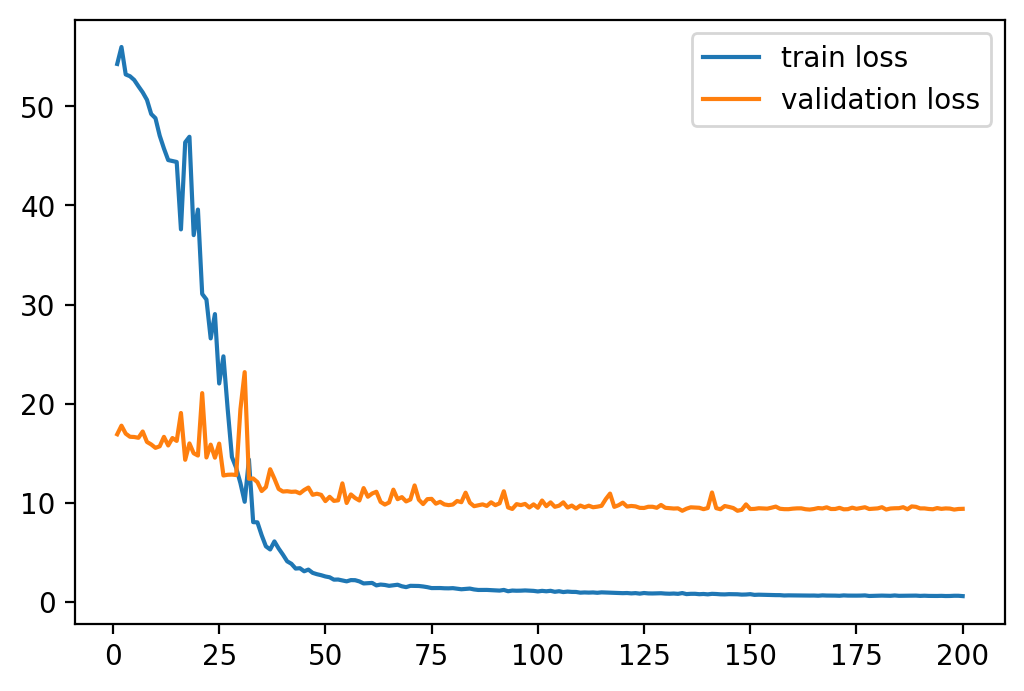

In [6]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss, label = 'train loss')
plt.plot(ep, validloss, label = 'validation loss')
plt.legend()
plt.show()

In [7]:
tsloss = 0
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = best_model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


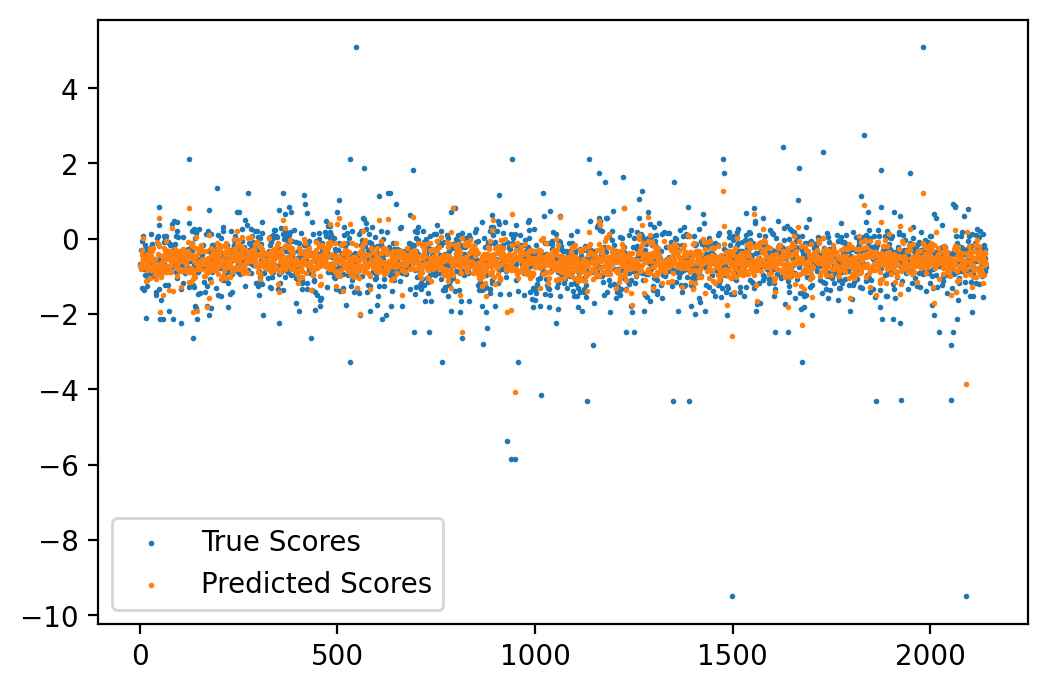

In [8]:
idx = np.array([i+1 for i in range(len(true_scores))])

plt.scatter(idx, true_scores, s=1, label = "True Scores")
plt.scatter(idx, pred_scores, s=1,label = "Predicted Scores")
plt.legend()
plt.show()

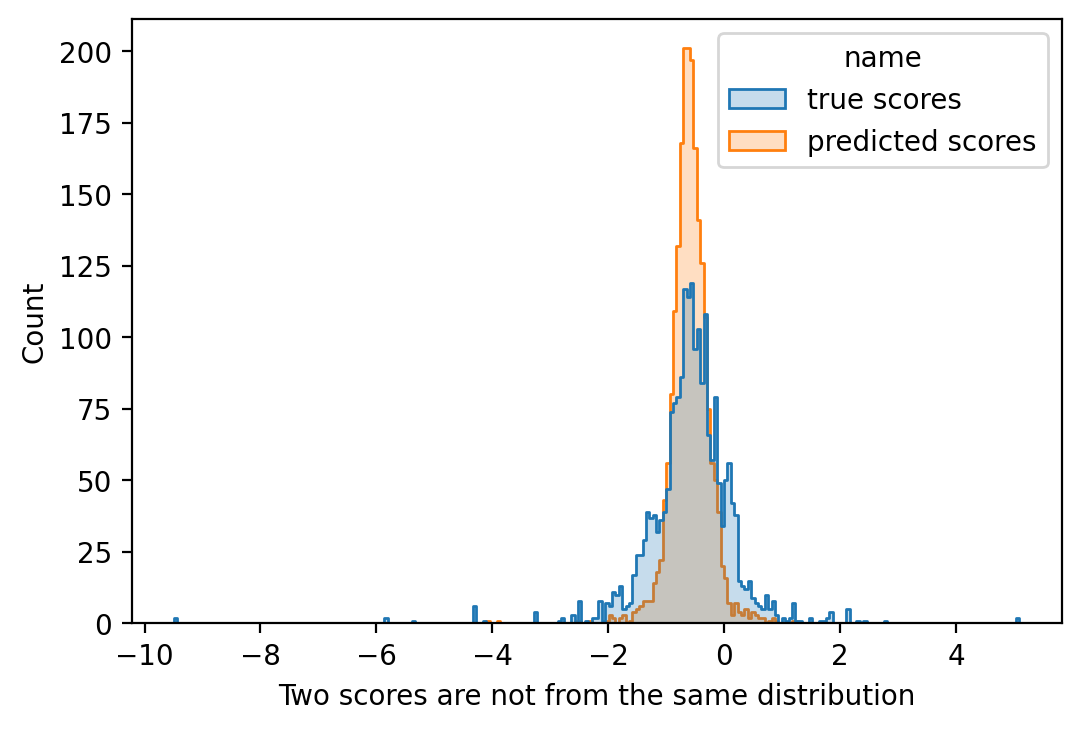

In [9]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'value': true_scores.ravel().tolist(), 'name':'true scores'})
dfy = pd.DataFrame.from_dict({'value': pred_scores.ravel().tolist(), 'name':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='value',hue='name',ax=ax, element='step')

if ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist())[1]<0.05:
    plt.xlabel('Two scores are not from the same distribution')
else:
    plt.xlabel('Two scores are from the same distribution')

In [32]:
ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist())[1]<0.05

True